# Определение возраста покупателей

**Иcходные данные**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. У нас в распоряжении датасет с фотографиями людей различных возрастов.


**Цель исследования**

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. MAE на тестовой выборке должно быть не больше 8.


**Ход исследования**

1. Обзор и исследовательский анализ набора данных.
2. Обучение модели.
3. Рассчет качества модели.
4. Вывод.

## Импорт библиотек

Импортируем библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

Загрузим и изучим данные

In [3]:
pth1 = 'labels.csv'
pth2 = '/datasets/faces/labels.csv'

if os.path.exists(pth1):
    labels = pd.read_csv(pth1)
elif os.path.exists(pth2):
    labels = pd.read_csv(pth2)
else:
    print('Файл не найден!')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=12345) 

Found 7591 validated image filenames.


Имеем 7591 объект. Выборка среднего размера.

Оценим параметры и собержание выборки

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Оценим плотность распределения возрастов

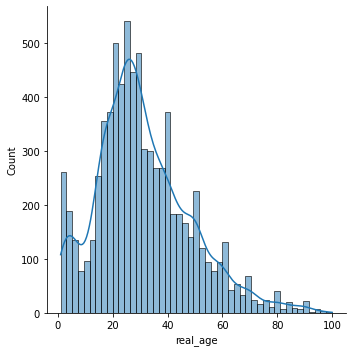

In [6]:
sns.displot(kde=True,
            data=labels['real_age']);

Наибольшее количество людей среднего возраста 18-42. Людей старше 60 мало, тем не менее есть фотографии до 100 лет.
Фотографий детей до 10 лет довольно много. Настораживает большое количество фотографий с возрастом близким к 0. Похоже на аномалию. 

Проверим, сколько объектов с возрастом 0.

In [7]:
labels.query('real_age == 0')['real_age'].count()

0

Проверим, сколько объектов с возрастом меньше 3.

In [8]:
labels.query('real_age < 3')['real_age'].count()

237

Взглянем на фотографии из датасета

Возраст человека на фото: 17


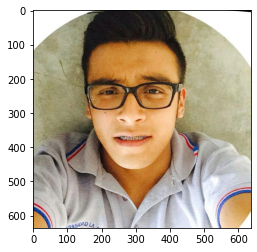


Возраст человека на фото: 51


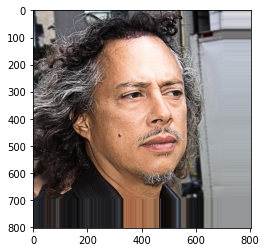


Возраст человека на фото: 2


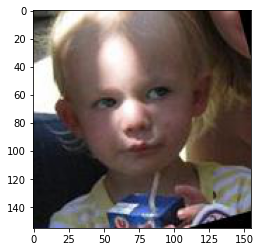


Возраст человека на фото: 1


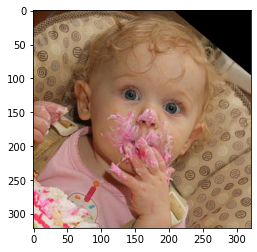


Возраст человека на фото: 6


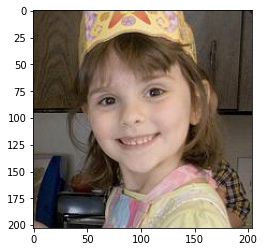


Возраст человека на фото: 18


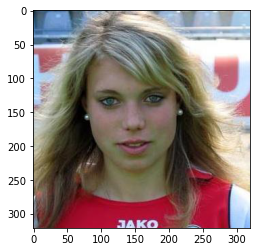


Возраст человека на фото: 24


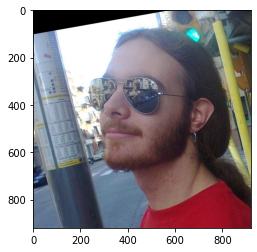


Возраст человека на фото: 5


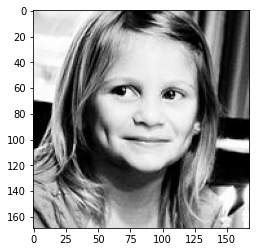


Возраст человека на фото: 40


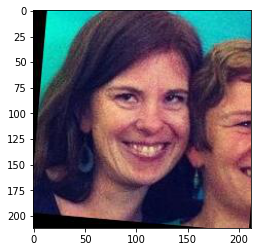


Возраст человека на фото: 16


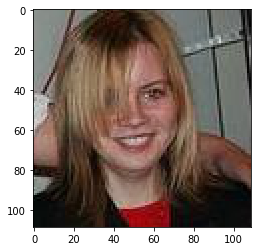


Возраст человека на фото: 29


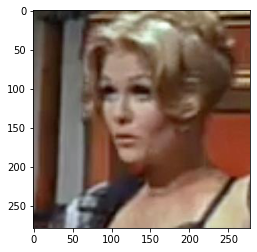


Возраст человека на фото: 1


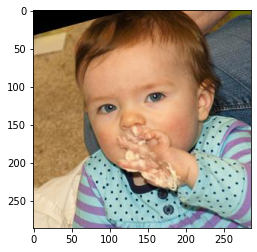


Возраст человека на фото: 35


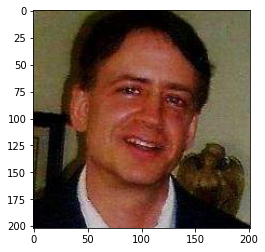


Возраст человека на фото: 25


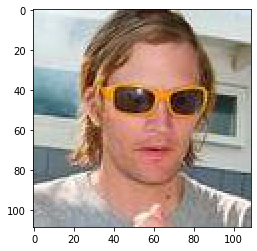


Возраст человека на фото: 5


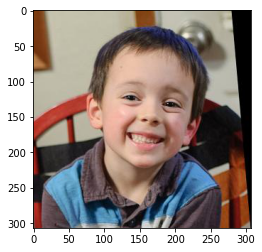


Возраст человека на фото: 30


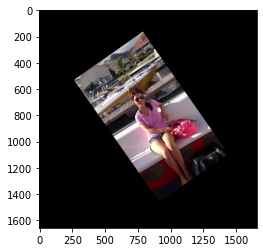

In [9]:
for i in range(10, 26):
    image = Image.open('/datasets/faces/final_files/' + labels.loc[i, 'file_name'])
    image_array = np.array(image)
    print('Возраст человека на фото:', labels.loc[i, 'real_age'])
    plt.imshow(image_array)
    plt.show()
    print()

На первый взгляд, возраста на фото соответствуют реальности. Аномалий не обнаружено. Есть фотографии разного качества, ракурсов, годов. У части фота изменен угол, присутствуют черные поля или шумы, что может хорошо сказаться на качестве обучения.

## Обучение модели

Код в этом разделе запускаелся в отдельном GPU-тренажёре.

Создадим функцию для загрузки обучающей выборки

In [ ]:
def load_train(path):
    
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255,
                                       horizontal_flip=True,
                                       rotation_range=30, 
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       zoom_range=0.1,)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path +'/final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age', 
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)
    return train_datagen_flow

Создадим функцию для загрузки тестировочной выборки

In [ ]:
def load_test(path):
    
    labels = pd.read_csv(path + '/labels.csv')
    valid_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255)

    test_datagen_flow = valid_datagen.flow_from_dataframe(dataframe=labels,
                                                          directory=path +'/final_files/',
                                                          x_col='file_name',
                                                          y_col='real_age',
                                                          target_size=(224, 224),
                                                          batch_size=32,
                                                          class_mode='raw',
                                                          subset='validation',
                                                          seed=12345)
    return test_datagen_flow

Создадим функцию для формирования модели

In [ ]:
def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

Создадим функцию для обучения и тестирования

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=11,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

## Рассчет качества модели

2022-10-31 08:42:52.386965: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-10-31 08:42:52.595317: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-10-31 08:42:56.594198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-31 08:42:57.223541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-31 08:42:57.223616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-31 08:42:57.223648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-31 08:42:57.289456: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-31 08:42:57.323882: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-31 08:42:57.649020: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-31 08:42:57.687183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-31 08:42:57.687265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-31 08:42:57.691766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-10-31 08:42:58.092425: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-10-31 08:42:58.124306: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-10-31 08:42:58.126205: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x428acb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-31 08:42:58.126234: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-31 08:42:58.358915: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x38eafd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-31 08:42:58.358954: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-10-31 08:42:58.361416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-31 08:42:58.361477: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-31 08:42:58.361488: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-31 08:42:58.361520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-31 08:42:58.361531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-31 08:42:58.361542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-31 08:42:58.361553: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-31 08:42:58.361561: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-31 08:42:58.365959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-10-31 08:42:58.368416: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-31 08:43:01.749614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-10-31 08:43:01.749660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-10-31 08:43:01.749668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-10-31 08:43:01.754151: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-31 08:43:01.754206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 5s
   81920/94765736 [..............................] - ETA: 1:02
  196608/94765736 [..............................] - ETA: 50s 
  491520/94765736 [..............................] - ETA: 29s
 1277952/94765736 [..............................] - ETA: 15s
 3203072/94765736 [>.............................] - ETA: 7s 
 7061504/94765736 [=>............................] - ETA: 3s
11165696/94765736 [==>...........................] - ETA: 2s
12591104/94765736 [==>...........................] - ETA: 2s
16785408/94765736 [====>.........................] - ETA: 2s
20488192/94765736 [=====>........................] - ETA: 2s
20979712/94765736 [=====>........................] - ETA: 2s
25174016/94765736 [======>.......................] - ETA: 2s
29368320/94765736 [========>.....................] - ETA: 2s
33562624/94765736 [=========>....................] - ETA: 1s
37756928/94765736 [==========>...................] - ETA: 1s
41951232/94765736 [============>.................] - ETA: 1s
46145536/94765736 [=============>................] - ETA: 1s
50339840/94765736 [==============>...............] - ETA: 1s
54501376/94765736 [================>.............] - ETA: 1s
54534144/94765736 [================>.............] - ETA: 1s
57647104/94765736 [=================>............] - ETA: 1s
58728448/94765736 [=================>............] - ETA: 1s
61841408/94765736 [==================>...........] - ETA: 1s
62922752/94765736 [==================>...........] - ETA: 1s
66052096/94765736 [===================>..........] - ETA: 0s
67117056/94765736 [====================>.........] - ETA: 0s
70262784/94765736 [=====================>........] - ETA: 0s
71311360/94765736 [=====================>........] - ETA: 0s
74473472/94765736 [======================>.......] - ETA: 0s
75505664/94765736 [======================>.......] - ETA: 0s
78684160/94765736 [=======================>......] - ETA: 0s
79699968/94765736 [========================>.....] - ETA: 0s
82894848/94765736 [=========================>....] - ETA: 0s
83894272/94765736 [=========================>....] - ETA: 0s
87105536/94765736 [==========================>...] - ETA: 0s
88088576/94765736 [==========================>...] - ETA: 0s
91316224/94765736 [===========================>..] - ETA: 0s
92282880/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 3s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/11
2022-10-31 08:43:26.959401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-31 08:43:28.998783: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 116s - loss: 260.2578 - mean_absolute_error: 11.6529 - val_loss: 692.6992 - val_mean_absolute_error: 21.3754
Epoch 2/11
178/178 - 88s - loss: 105.3323 - mean_absolute_error: 7.7056 - val_loss: 687.8338 - val_mean_absolute_error: 21.2713
Epoch 3/11
178/178 - 88s - loss: 82.3446 - mean_absolute_error: 6.8596 - val_loss: 340.7192 - val_mean_absolute_error: 13.5509
Epoch 4/11
Epoch 5/11
178/178 - 88s - loss: 72.4399 - mean_absolute_error: 6.4237 - val_loss: 119.1346 - val_mean_absolute_error: 8.1657
178/178 - 88s - loss: 61.0391 - mean_absolute_error: 5.9787 - val_loss: 77.5033 - val_mean_absolute_error: 6.5714
Epoch 6/11
178/178 - 88s - loss: 53.2891 - mean_absolute_error: 5.5855 - val_loss: 76.7904 - val_mean_absolute_error: 6.5274
Epoch 7/11
178/178 - 88s - loss: 47.6406 - mean_absolute_error: 5.3298 - val_loss: 76.9516 - val_mean_absolute_error: 6.4445
Epoch 8/11
178/178 - 89s - loss: 41.9608 - mean_absolute_error: 5.0023 - val_loss: 81.8613 - val_mean_absolute_error: 6.6164
Epoch 9/11
178/178 - 88s - loss: 38.8599 - mean_absolute_error: 4.8157 - val_loss: 71.4283 - val_mean_absolute_error: 6.2431
Epoch 10/11
178/178 - 89s - loss: 34.3340 - mean_absolute_error: 4.5147 - val_loss: 100.7339 - val_mean_absolute_error: 7.7986
Epoch 11/11
178/178 - 88s - loss: 35.0267 - mean_absolute_error: 4.5023 - val_loss: 75.6497 - val_mean_absolute_error: 6.4628
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 75.6497 - mean_absolute_error: 6.4628
Test MAE: 6.4628

Мы получили MAE 6.46 на тестовой выборке.

## Вывод

По полученному датасету мы построили модель ResNet50, предобученную на данных Imagenet, способную предсказать прибизительный возраст покупателя с погрешностью примерно в 6,5 лет.